In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image

In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [3]:
infd = open('vezone.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

print(data.shape)

(14668725,)


In [4]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

(955500,)
uint8 (525, 1820) (525, 1820)


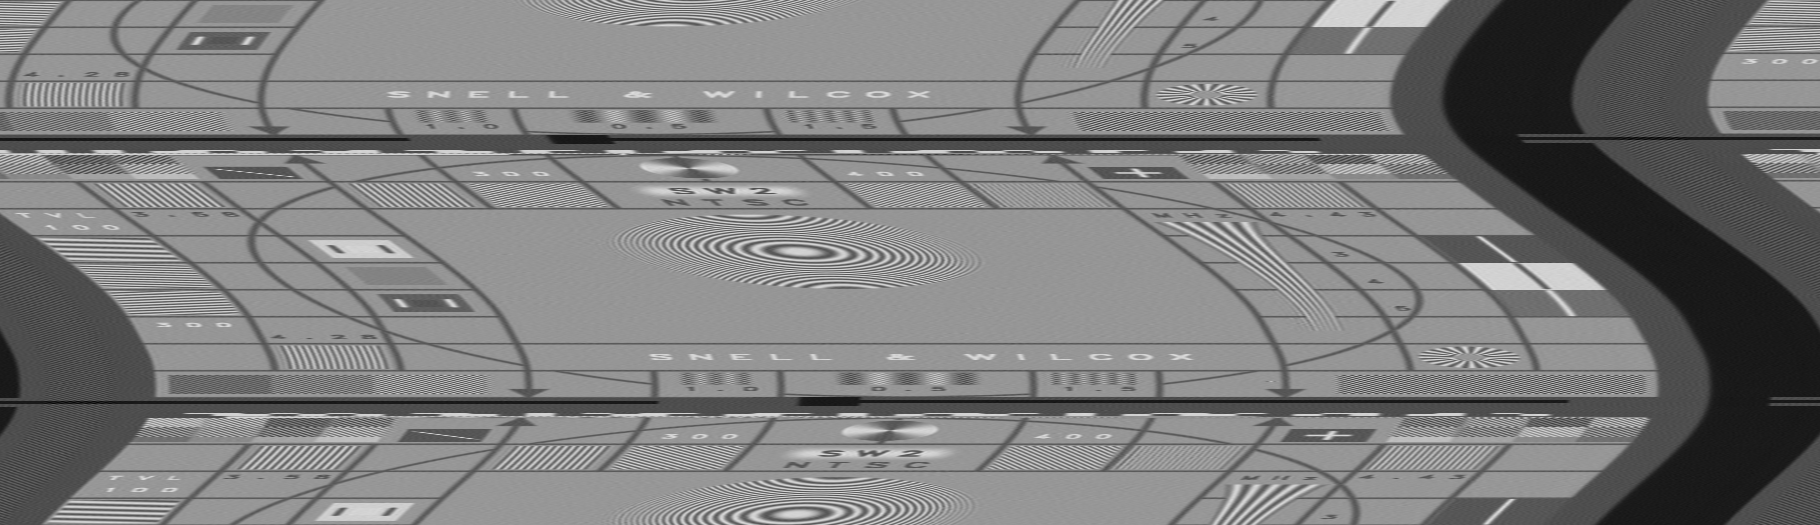

In [5]:
drawdata(data)

In [6]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

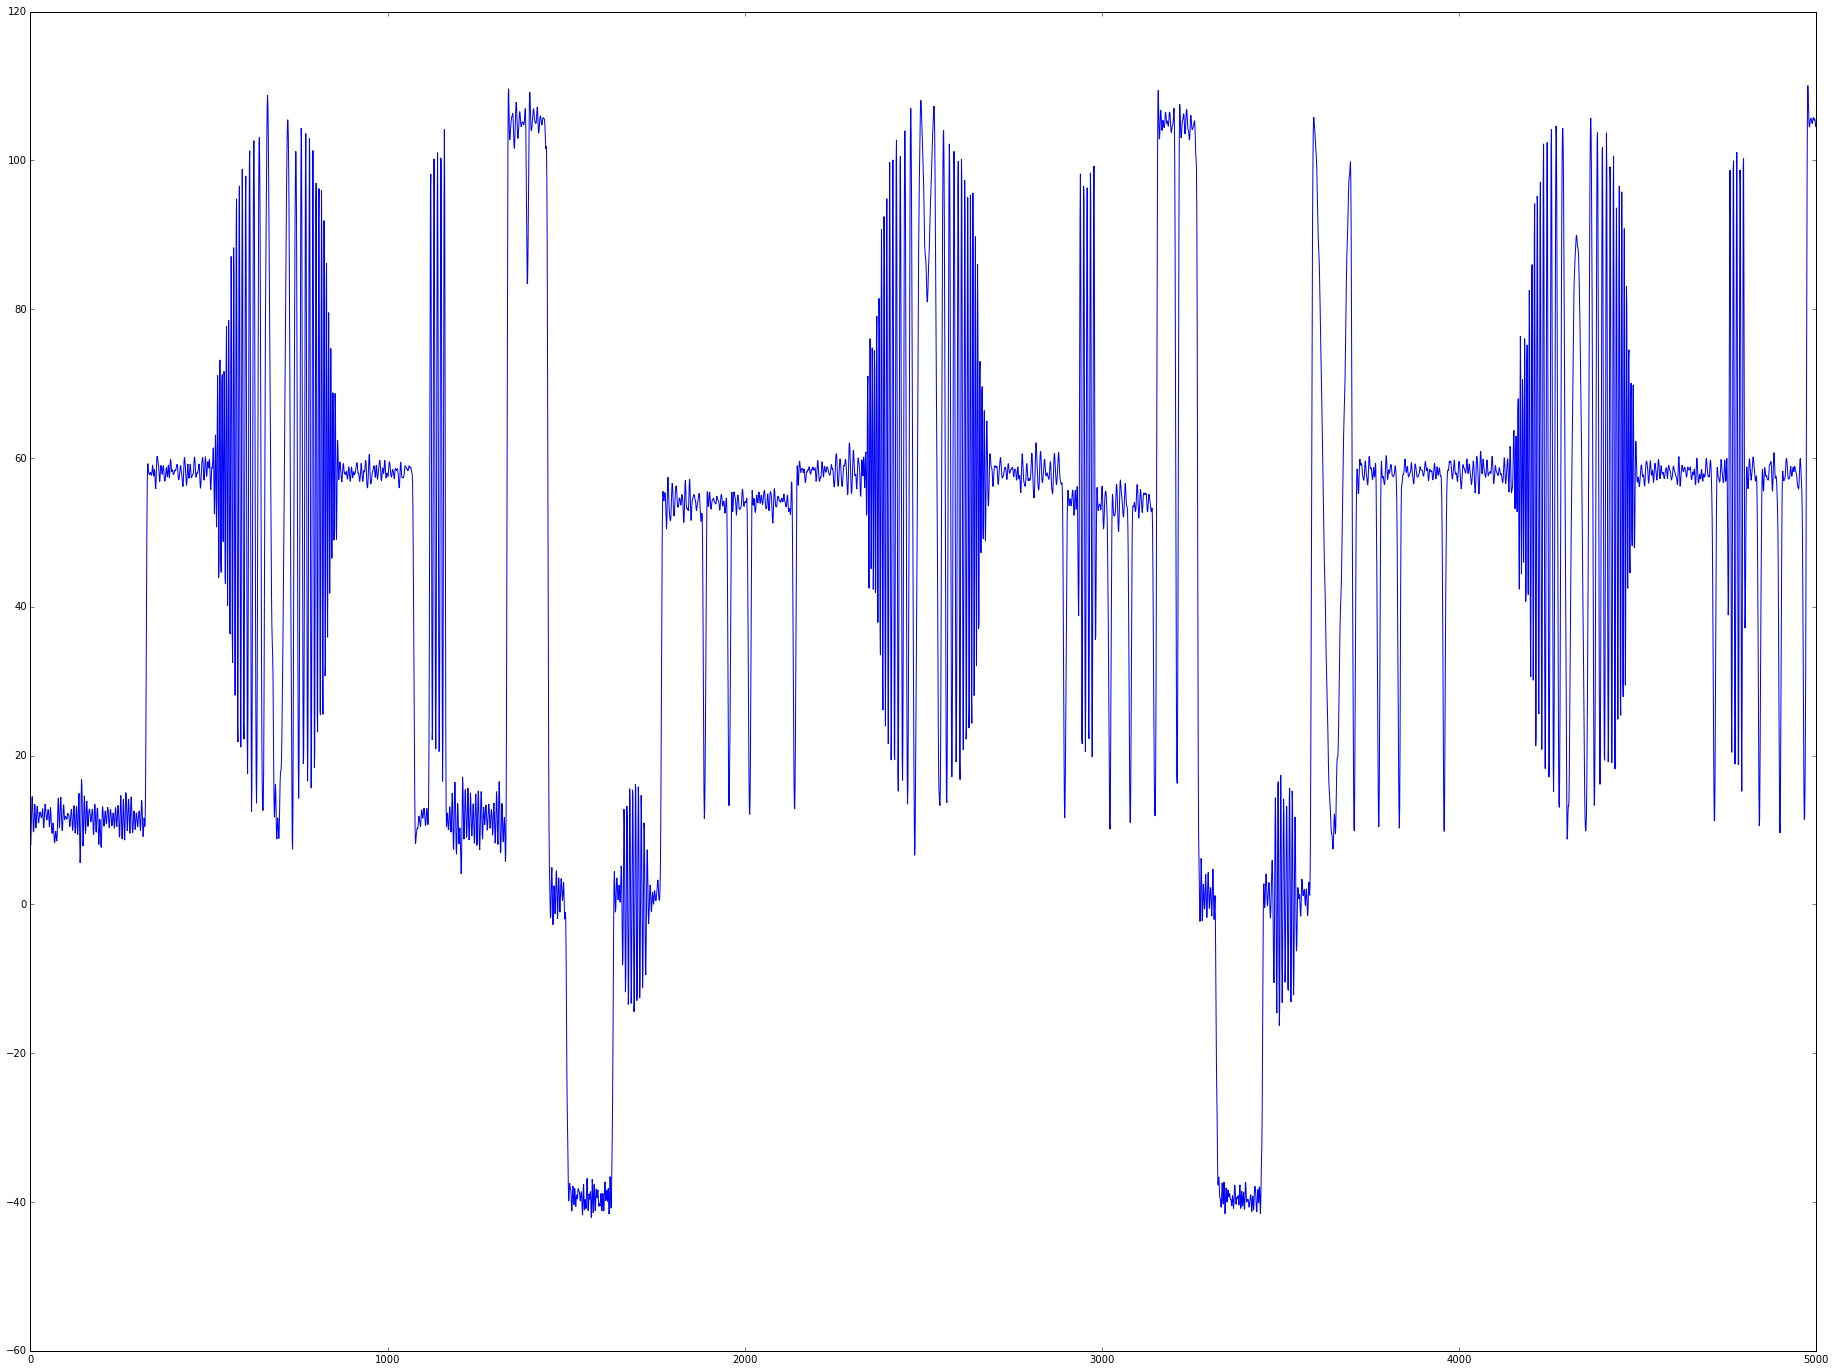

In [7]:
plt.plot(RawToIRE(data[0:5000]))

In [8]:
synctrig = IREToRaw(-21)
sdata = data < synctrig

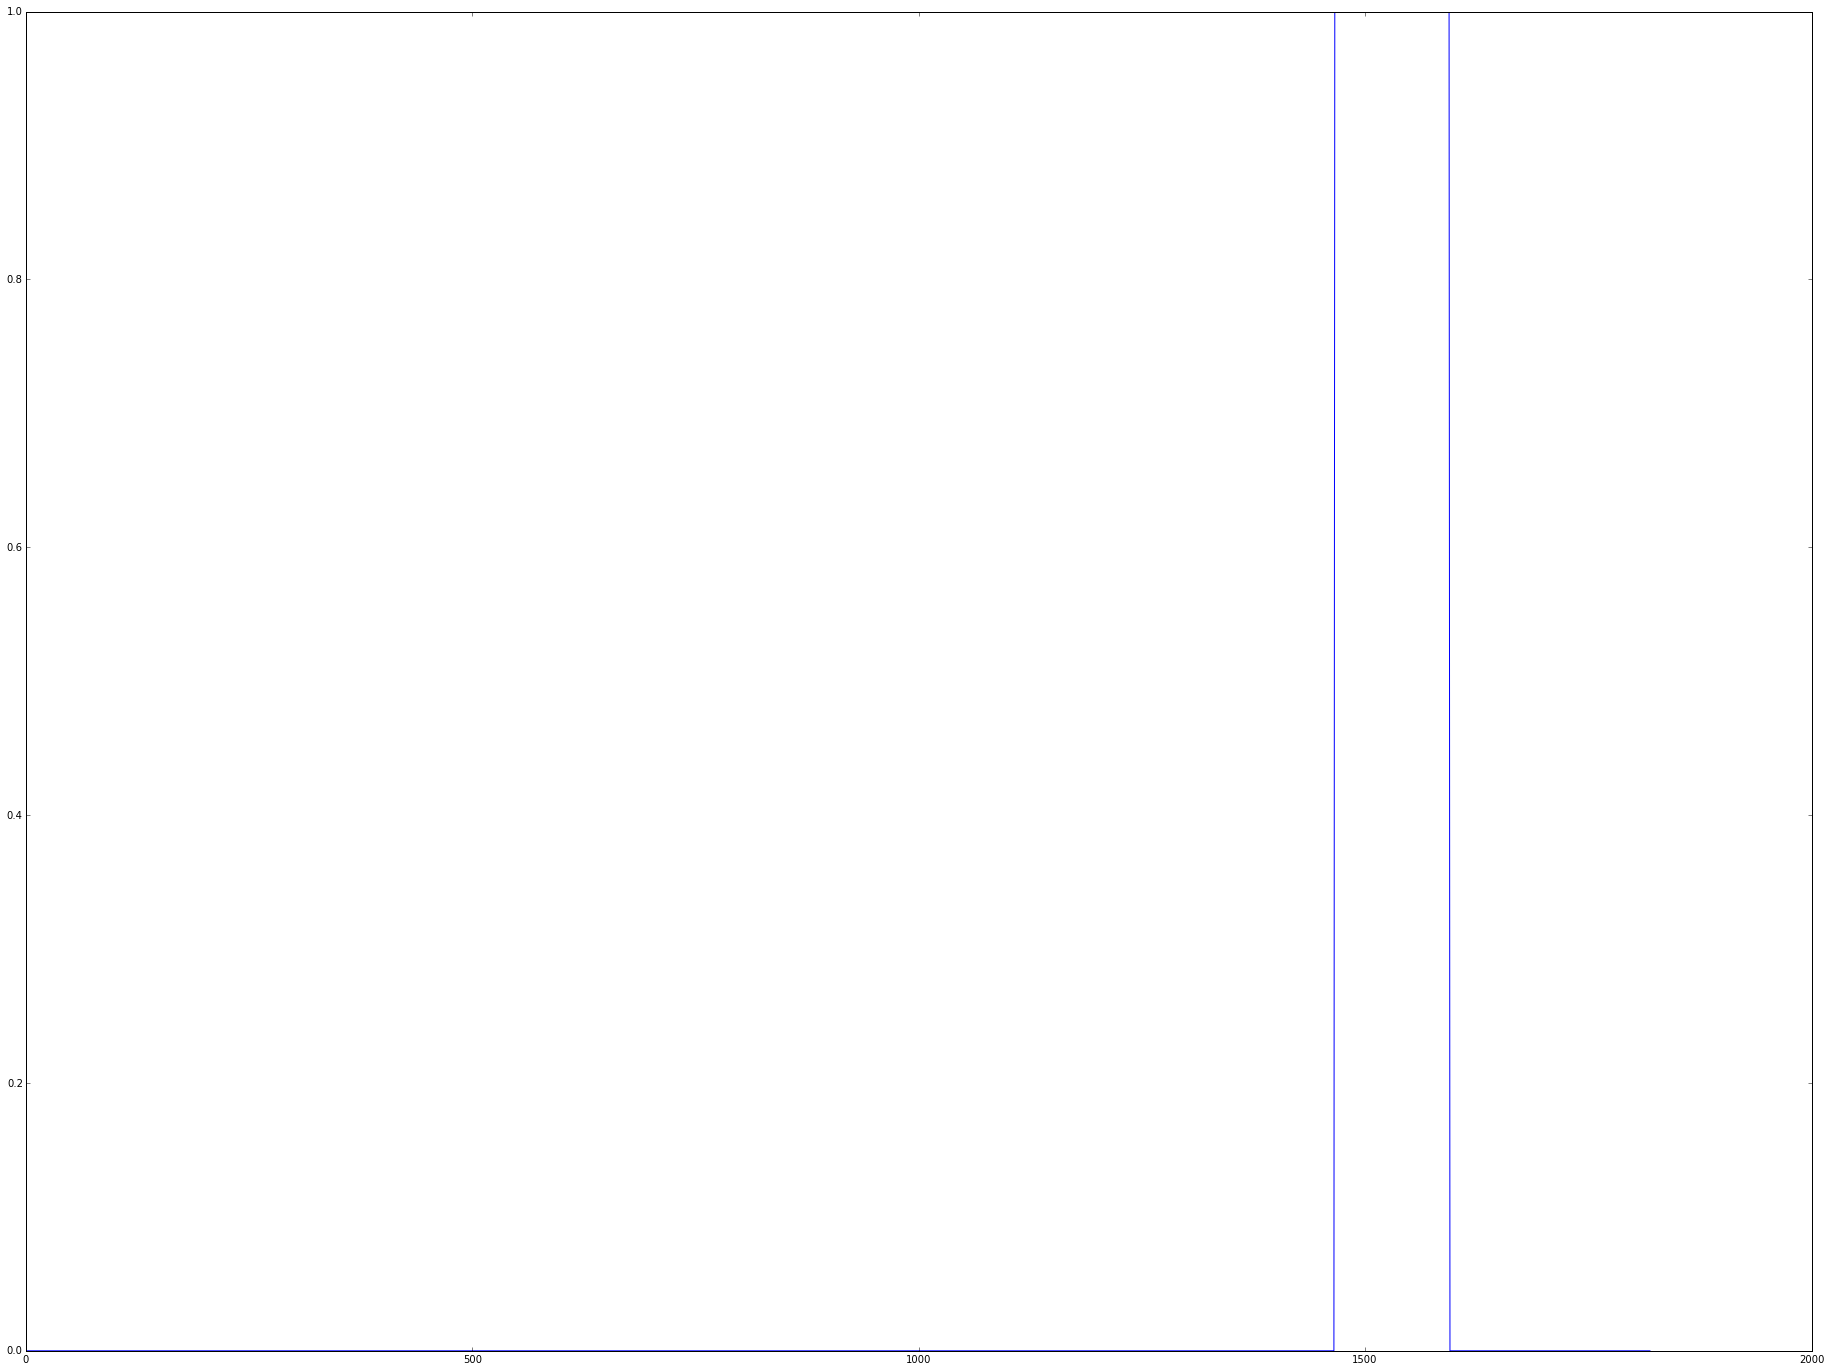

In [9]:
plt.plot(sdata[78260:78260+1820])

In [10]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0

Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
    return np.where(dpeaks)[0] 
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320

#sfdata = None

def findsyncs(data):
#    global sfdata
    # Parameters
    synctrig = IREToRaw(-25) # this value should be below any likely colorburst for NTSC
    hslen = range(FSC * 14, FSC * 17) # typical range of horizontal syncs at synctrig level
    scanlength = int(FSC * (227.5 * 1.25)) # long enough to cover an entire line, but not long enough to see the half-line hsync as well
    
    sdata = data < synctrig
    sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
    
    peaks = findpeaks(sfdata)
#    print (peaks)
    vsyncs = []
    cvsync = None
    
    # we need to detect the gaps before/after the last full vsync pulse to the prev/next regular hsync,
    # to see which kind of field we're dealing with
    previ = 0
    prevv = 0
    for i in peaks:
        if sfdata[i] > 0.5:
            if previ == None:
                return (1820 * 500), None, None
            
            if len(vsyncs) == 0 or cvsync['gap2'] is not None:
                cvsync = {'hsyncs': [], 'gap1': (i - previ), 'gap2': None}
                vsyncs.append(cvsync)
            
            prevv = i
        elif sfdata[i] > 0.25:
            if cvsync is not None:
                if cvsync['gap2'] is None:
                    cvsync['gap2'] = i - prevv
                    
                cvsync['hsyncs'].append(i)
                
            previ = i
    
    # return a few lines back before the last vsync, so the next read can start correctly
    return vsyncs[-2]['hsyncs'][-3], vsyncs, sfdata

from datetime import datetime
ts = datetime.now()
rlen, peaks, sfdata = findsyncs(data)
print(datetime.now() - ts)

0:00:00.168299


In [12]:
from scipy import interpolate

# This uses numpy's interpolator, which provides very good results
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [ ]:
def dumb_frameup(data, peaks, sfdata, start = 1000000):
    print(len(peaks))
    
    frame = np.zeros(525)
    framebuf = np.zeros(910 * 525, dtype=np.uint16)
    
    frameno = -1
    for i in range(0, len(peaks)):
        if peaks[i]['hsyncs'][0] < start:
            continue
        
        field = peaks[i]
        is_even = (field['gap1'] / float(field['gap2'])) < 1.05
        
        # wait until the start of a new frame
        if is_even == 0 and frameno < 0:
            frameno = 0
        
        if frameno >= 0:
            for i in range(1, len(field['hsyncs']) - 1):
                # compute line #
                l = (i - 1) * 2
                if is_even != 0:
                    l += 1
                
                linestart = field['hsyncs'][i]
                line2start = (field['hsyncs'][i + 1])
#                line2start = field['hsyncs'][i] + 1820
 
                lx = scale(data, linestart, line2start, 910)
                framebuf[l * 910:((l + 1) * 910)] = lx[0:910]

                frame[l] = linestart
                
            if is_even == 1:
                return frame, framebuf, None

for i in range(0,2):
    frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
    
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [15]:
# set up sync color heterodyne table first 
freq = FSC / 2.0

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (FSC / 2.0)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

def burst_detect(data):
        level = 0
        phase = 0

        data = data.astype(np.float32)
        data -= np.mean(data)
        
        obhet = bhet[0:len(data)] * data
        
        obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
        obhet_levels = np.fabs(np.absolute(obhet_filt))
        obhet_angles = np.angle(obhet_filt)

        for i in range(0, len(data)):
            if (obhet_levels[i] > level) and (obhet_levels[i] < (out_scale * 30)):
                level = obhet_levels[i]
                phase = obhet_angles[i]

        return [level, phase]
    
def wrap_angle(angle, tgt):
        adjust = tgt - angle
        
        if (adjust > (np.pi)):
                adjust -= 2 * np.pi
        elif (adjust < (-np.pi)):
                adjust += 2 * np.pi

        return adjust

# phasemult = (np.pi / 2.0) * freq * 2
phasemult = 1 / (2 * np.pi) * FSC

31
field : 2
field : 3
0:00:01.539692
(477750,)
uint8 (525, 910) (525, 910)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


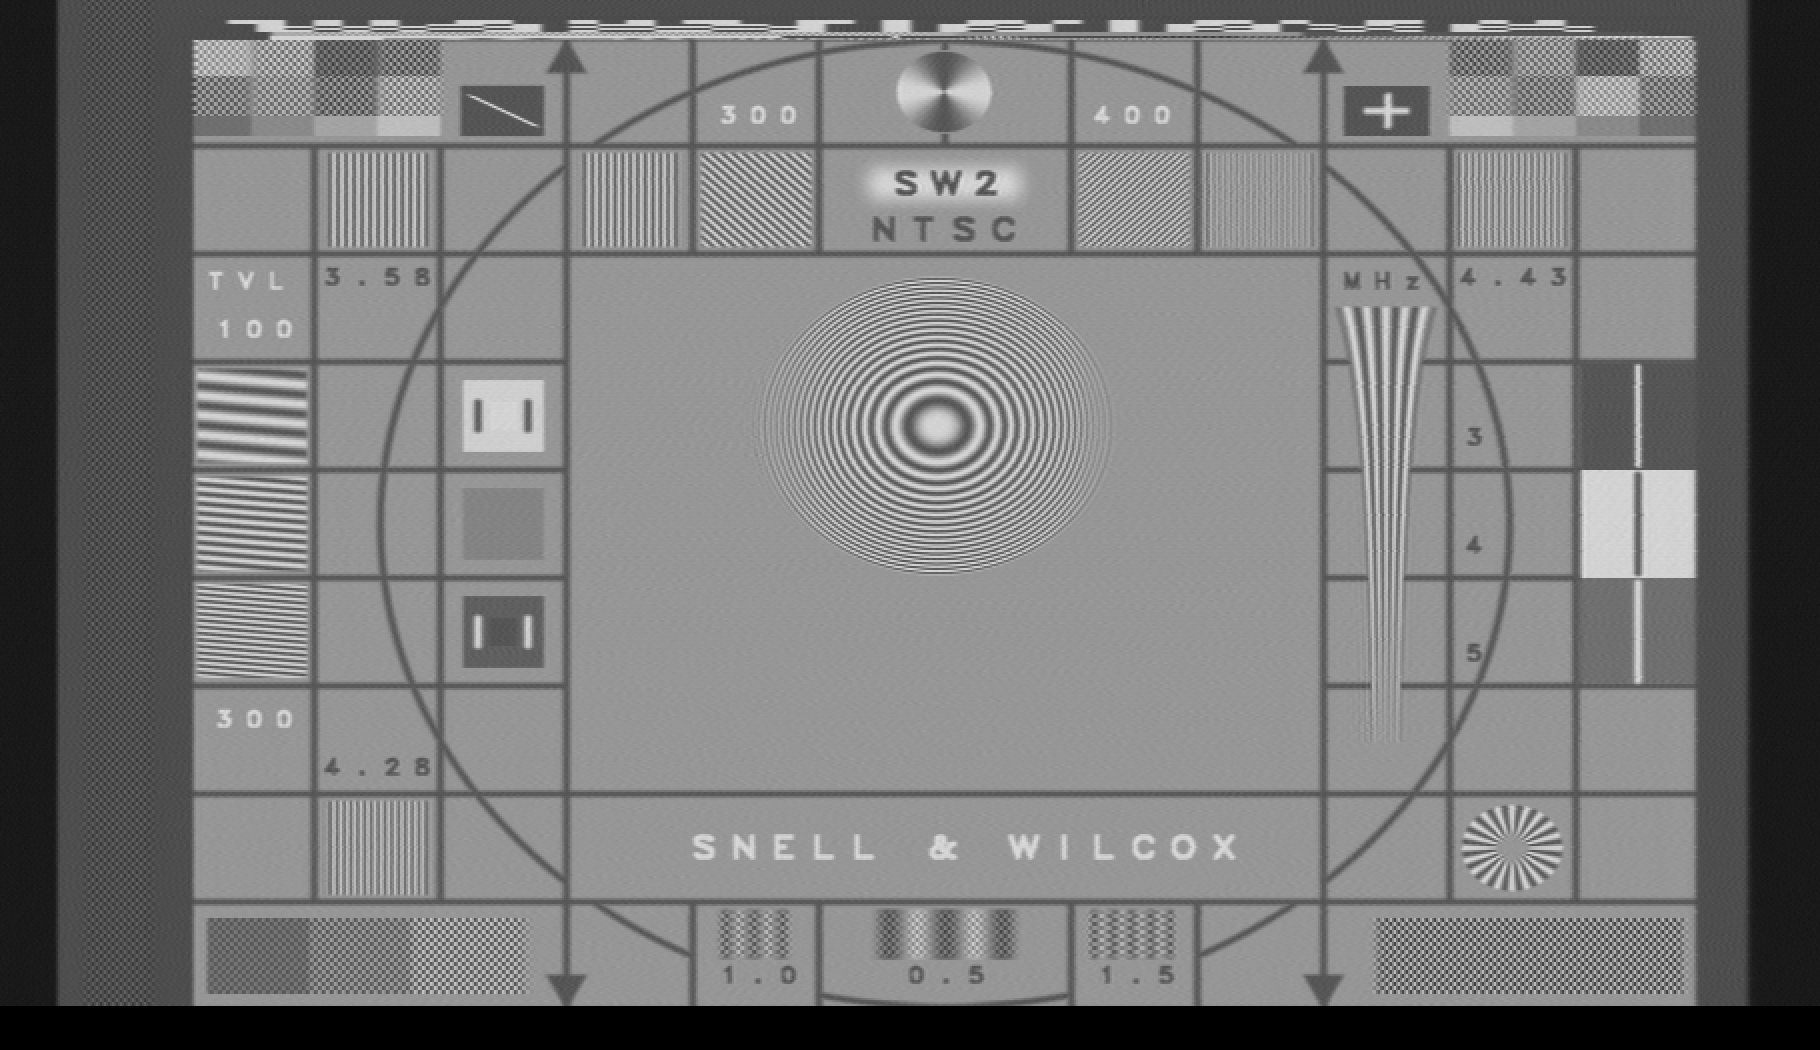

In [57]:
def frameup(data, peaks, sfdata, start = 1000000, tolerance = .025):
    print(len(peaks))
    
    frame = np.zeros(525)
    
    framebuf = np.zeros(910 * 525, dtype=np.uint16)
    phases = np.zeros(525)
    
    frameno = -1
    for i in range(0, len(peaks)):
        if peaks[i]['hsyncs'][0] < start:
            continue
        
        print("field :", i)
        
        field = peaks[i]
        is_even = (field['gap1'] / float(field['gap2'])) < 1.05
        
        # wait until the start of a new frame
        if is_even == 0 and frameno < 0:
            frameno = 0
        
        if frameno >= 0:
            for i in range(1, len(field['hsyncs']) - 1):
                # compute line #
                l = (i - 1) * 2
                if is_even != 0:
                    l += 1
                
                for run in range(0, 10):
                    linestart = field['hsyncs'][i]
                    
                    line2_postcb = ((field['hsyncs'][i + 1] - linestart) * (260/227.5)) + linestart
                    lx = scale(data, linestart, line2_postcb, 260 * (FSC / 2.0))
                    framebuf[l * 910:((l + 1) * 910)] = lx[0:910]

                    phases[l] = burst_detect(lx[32:86])[1]
                    nextphase = burst_detect(lx[32+(4*227):86+(4*227)])[1]
                    ptgt = np.pi if (np.fabs(phases[l]) > (np.pi/2)) else 0
        
#                    print(i, l, ptgt, phases[l], nextphase)
        
                    adj1 = wrap_angle(phases[l], ptgt)
                    adj2 = wrap_angle(nextphase, ptgt)
                
                    if (np.fabs(adj1) < tolerance) and (np.fabs(adj2) < tolerance):
#                        print(i, 'good')
                        break

                    field['hsyncs'][i] += phasemult * adj1
                    field['hsyncs'][i + 1] += phasemult * adj2
            
                    frame[l] = field['hsyncs'][i]
            
            if is_even == 1:
                return frame, framebuf, phases
            
rlen, peaks, sfdata = findsyncs(data)
ts = datetime.now()
for i in range(0,1):
    frame, framebuf, phases = frameup(data, peaks, sfdata)
print(datetime.now() - ts)
    
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [ ]:
print((500 / freq) * 2.0 * np.pi)

In [ ]:
print((500 / (FSC / 2.0)) * 2 * np.pi)

In [32]:
wrap_angle(np.pi, -2.80443301557)

0.3371596380197932

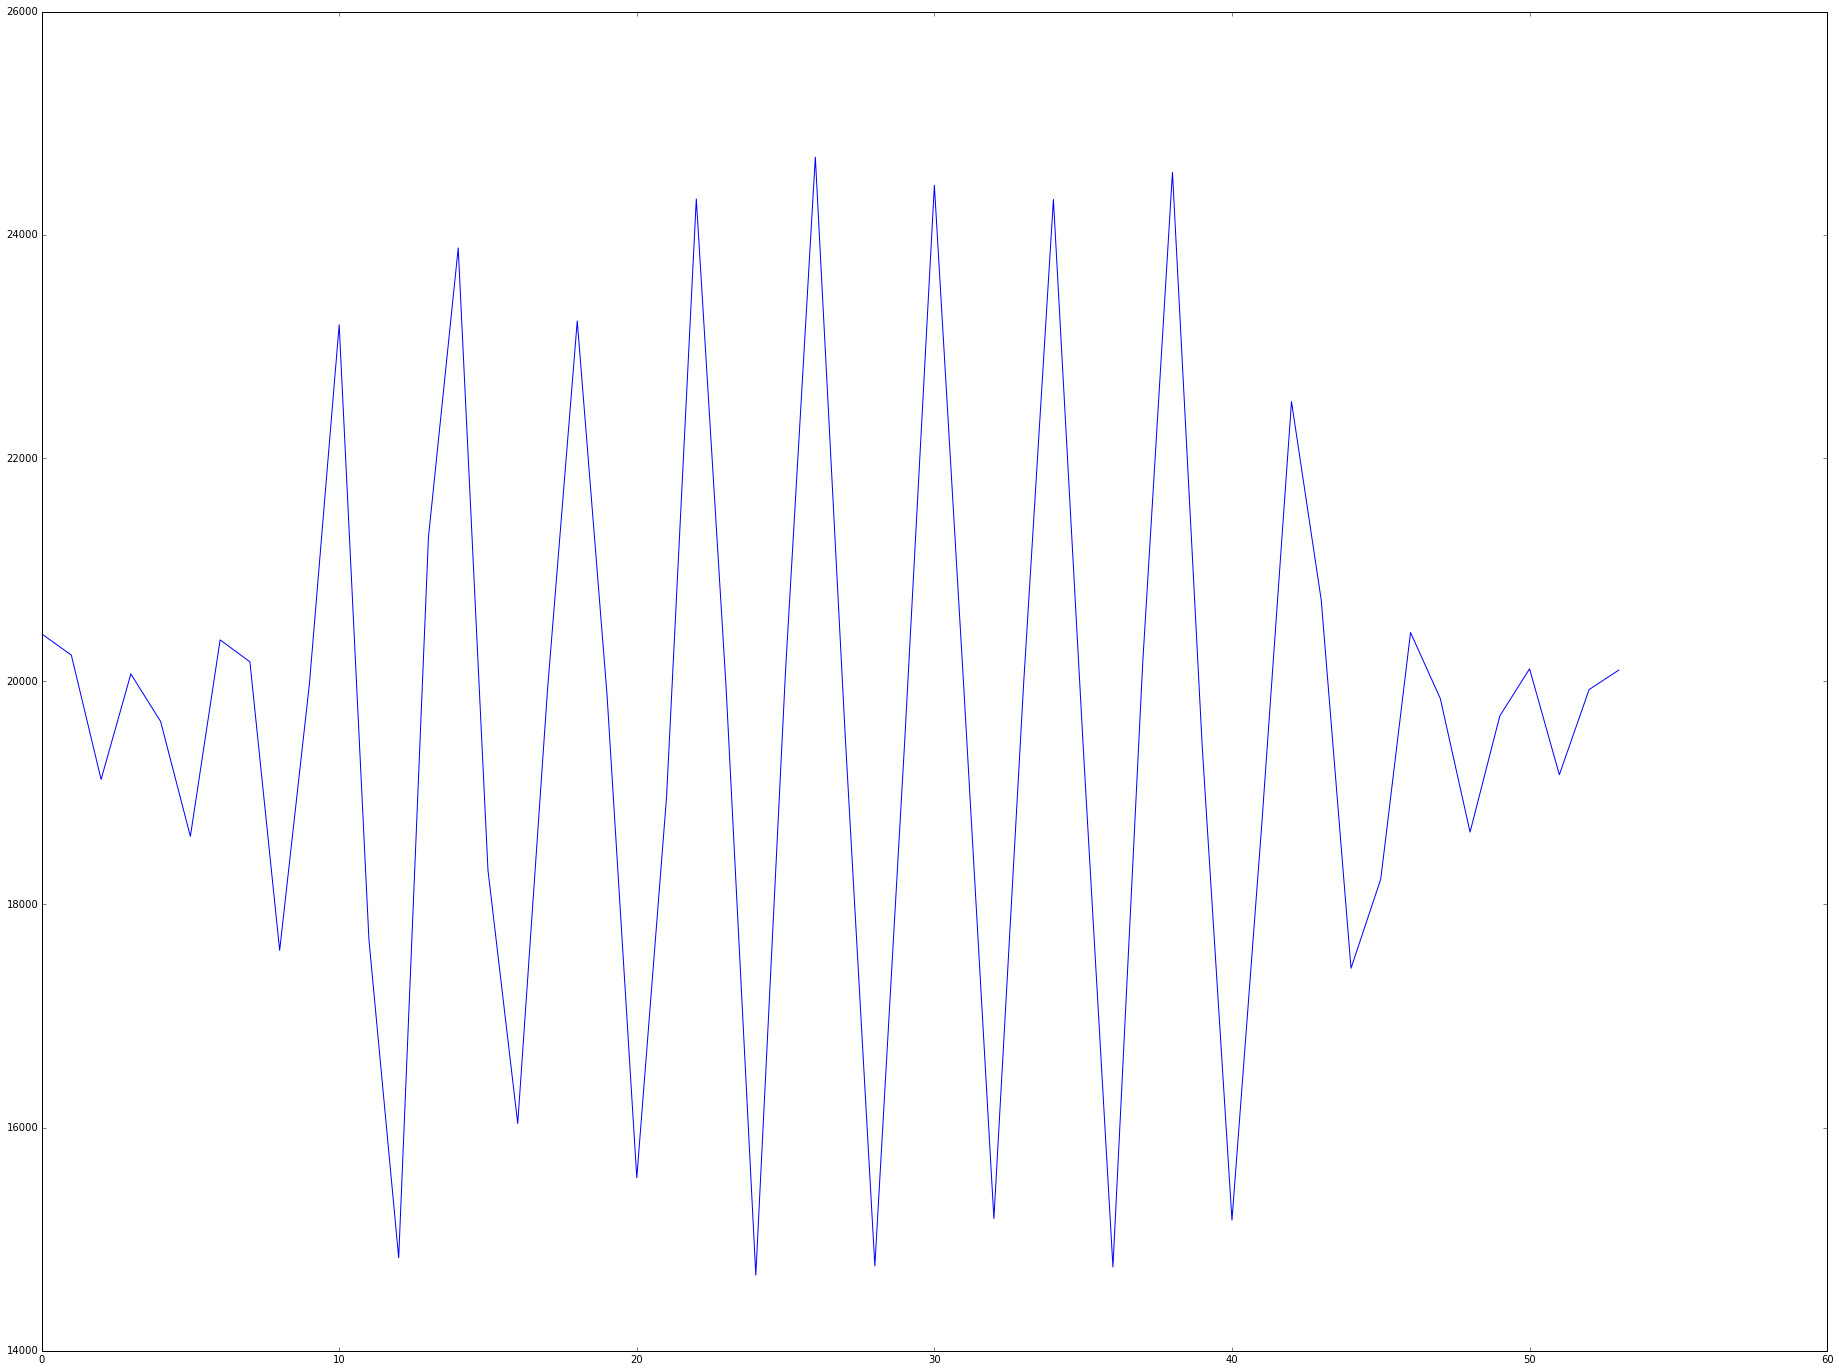

In [44]:
ind = 910 * 40
plt.plot(framebuf[ind+32:ind+86])

In [46]:
4*227

908

In [47]:
998/910

1.0967032967032968

In [48]:
1.1*910

1001.0000000000001

In [49]:
4*230

920

In [52]:
4*260

1040

In [53]:
260/227.5

1.1428571428571428